<center><h1>Panchal_Apoorva_HW6</h1></center>

Name: Apoorva Panchal
<br>
Github Username: ApoorvaPanchal
<br>
USC ID: 8685016290

Used 1 late day.

## 1. Tree-Based Methods

Import packages

In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from urllib.request import urlretrieve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from scikitplot.metrics import plot_roc
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from tabulate import tabulate

### (a) Download the APS Failure data

In [2]:
# url = 'https://archive.ics.uci.edu/static/public/421/aps+failure+at+scania+trucks.zip'
# filename = '../data/aps_failure.zip'
# urlretrieve(url, filename)

In [3]:
# zip = zipfile.ZipFile('../data/aps_failure.zip', 'r').extractall('../data/')
train_df = pd.read_csv('../data/aps_failure_training_set.csv', na_values='na', skiprows=20)
test_df = pd.read_csv('../data/aps_failure_test_set.csv', na_values='na', skiprows=20)

X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

* One of the methods used is to fill the data either with a random vaue or a statistical value such as mean, median or mode based on the type of features (categorical or quantitative)   
* We can use the train data to train the model and predict the missing values based on the other values using regression techniques such as Linear Regression, kNN for quantitative features or decision tree models for categorical features.   
* We can also use Iterative Multiple Imputation based on Expectation Maximization   
   
    
Here, I am using the simple imputer to fill the missing values based on the median values as any outliers may cause a huge impact on the mean

In [4]:
combined_df = pd.concat([X_train, X_test])
X_train.isnull().sum().sum()

850015

In [5]:
nan_val = 'na'
# imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_model = imputer.fit(X_train)
X_train = pd.DataFrame(imputer_model.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer_model.transform(X_test), columns=X_test.columns)

#### (ii) Calculate the coefficient of variation

In [6]:
combined_df = pd.concat([X_train, X_test])

In [7]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
cv_aps = combined_df.apply(cv).to_dict()
print('Coefficient of Variation : ', cv_aps)

Coefficient of Variation :  {'aa_000': 432.86078354357426, 'ab_000': 974.0521413405515, 'ac_000': 230.9299211681413, 'ad_000': 27479.15807406114, 'ae_000': 2327.135687575111, 'af_000': 1900.7953496912637, 'ag_000': 9250.75102690456, 'ag_001': 4256.614498697585, 'ag_002': 1782.796341591406, 'ag_003': 885.4130035473667, 'ag_004': 553.8277908616694, 'ag_005': 299.4139854561651, 'ag_006': 236.4870820852844, 'ag_007': 283.8123679270417, 'ag_008': 634.3974458817221, 'ag_009': 3253.539492235538, 'ah_000': 232.7388769583548, 'ai_000': 1870.1475814068804, 'aj_000': 4359.894598653089, 'ak_000': 8487.5146250108, 'al_000': 921.0860085155642, 'am_0': 916.3254873251835, 'an_000': 226.5640850870999, 'ao_000': 228.6947012092914, 'ap_000': 310.8148701141875, 'aq_000': 287.117145995108, 'ar_000': 1107.9623721014384, 'as_000': 11508.207704216715, 'at_000': 2343.1462812495274, 'au_000': 8699.224820579382, 'av_000': 595.7936005046938, 'ax_000': 400.1075296454543, 'ay_000': 4137.245105927233, 'ay_001': 4981

#### (iii) Plot a correlation matrix

In [8]:
corr_aps = combined_df.corr()
print('Correlation Matrix : ', corr_aps)

Correlation Matrix :            aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.009953 -0.037851 -0.000801  0.023778  0.033524  0.011686   
ab_000  0.009953  1.000000 -0.002489 -0.000372  0.034129  0.053156 -0.000206   
ac_000 -0.037851 -0.002489  1.000000 -0.001568 -0.004005 -0.009773  0.015077   
ad_000 -0.000801 -0.000372 -0.001568  1.000000 -0.000156 -0.000190 -0.000038   
ae_000  0.023778  0.034129 -0.004005 -0.000156  1.000000  0.830001 -0.000465   
...          ...       ...       ...       ...       ...       ...       ...   
ee_007  0.356954  0.010747 -0.048884 -0.000722  0.034168  0.043477  0.007652   
ee_008  0.259626 -0.026319 -0.004806 -0.001060 -0.009518 -0.012225  0.000102   
ee_009  0.133790 -0.017057  0.012019 -0.000622 -0.007330 -0.009004 -0.001082   
ef_000  0.005648  0.051733 -0.006200 -0.000072  0.063622  0.093517 -0.000086   
eg_000  0.009239  0.077262  0.016273 -0.000076  0.030893  0.044417  0.000145   

          ag_001 

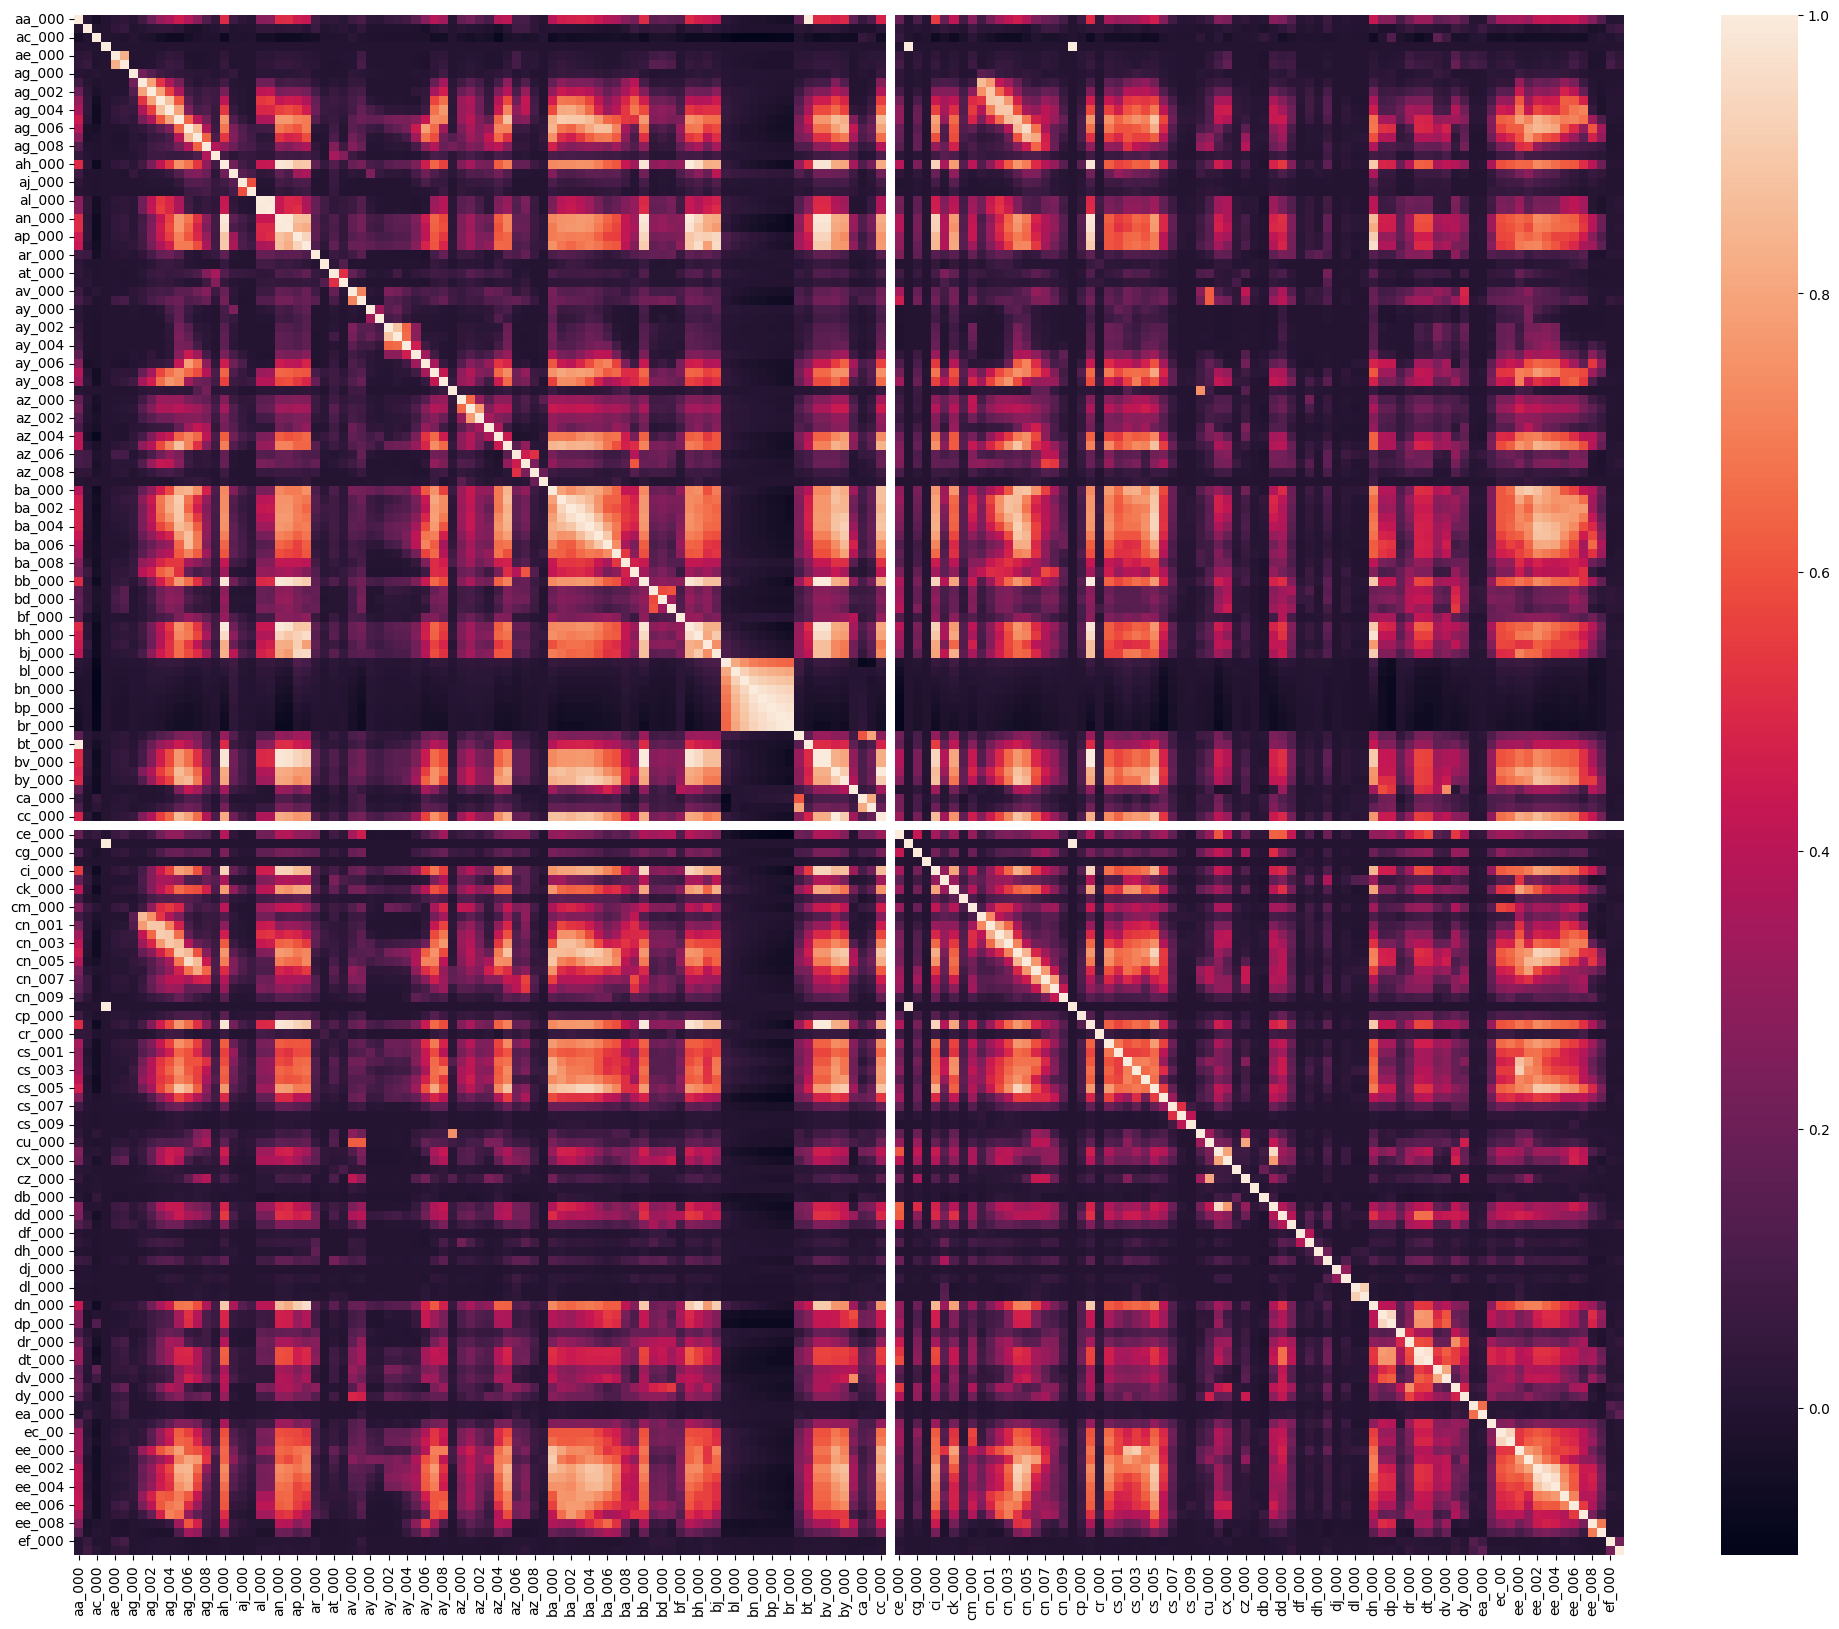

In [9]:
fig = plt.figure(figsize=(25,20))
_ = sns.heatmap(corr_aps)

In [10]:
y_train = y_train.replace({'neg': 0, 'pos': 1})
y_test = y_test.replace({'neg': 0, 'pos': 1})

In [11]:
print(y_train)

0        0
1        0
2        0
3        0
4        0
        ..
59995    0
59996    0
59997    0
59998    0
59999    0
Name: class, Length: 60000, dtype: int64


#### (iv) Make scatter plots and box plots

In [12]:
highest = {k: v for k, v in sorted(cv_aps.items(), key=lambda item: item[1], reverse=True)} 
highest_keys = list(highest.keys())
selected_features = []
for i in range(0,13):
    selected_features.append(highest_keys[i])

print(selected_features)

['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'dh_000', 'df_000', 'as_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009']


In [13]:
train_df_imputed = pd.concat([X_train, y_train], axis = 1)

In [14]:
print(train_df_imputed)

         aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0       76698.0     0.0  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1       33058.0     0.0  0.000000e+00   126.0     0.0     0.0     0.0     0.0   
2       41040.0     0.0  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3          12.0     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4       60874.0     0.0  1.368000e+03   458.0     0.0     0.0     0.0     0.0   
...         ...     ...           ...     ...     ...     ...     ...     ...   
59995  153002.0     0.0  6.640000e+02   186.0     0.0     0.0     0.0     0.0   
59996    2286.0     0.0  2.130707e+09   224.0     0.0     0.0     0.0     0.0   
59997     112.0     0.0  2.130706e+09    18.0     0.0     0.0     0.0     0.0   
59998   80292.0     0.0  2.130706e+09   494.0     0.0     0.0     0.0     0.0   
59999   40222.0     0.0  6.980000e+02   628.0     0.0     0.0     0.0     0.0   

       ag_002  ag_003  ... 

In [15]:
selected_features.append('class')

<Figure size 2500x2000 with 0 Axes>

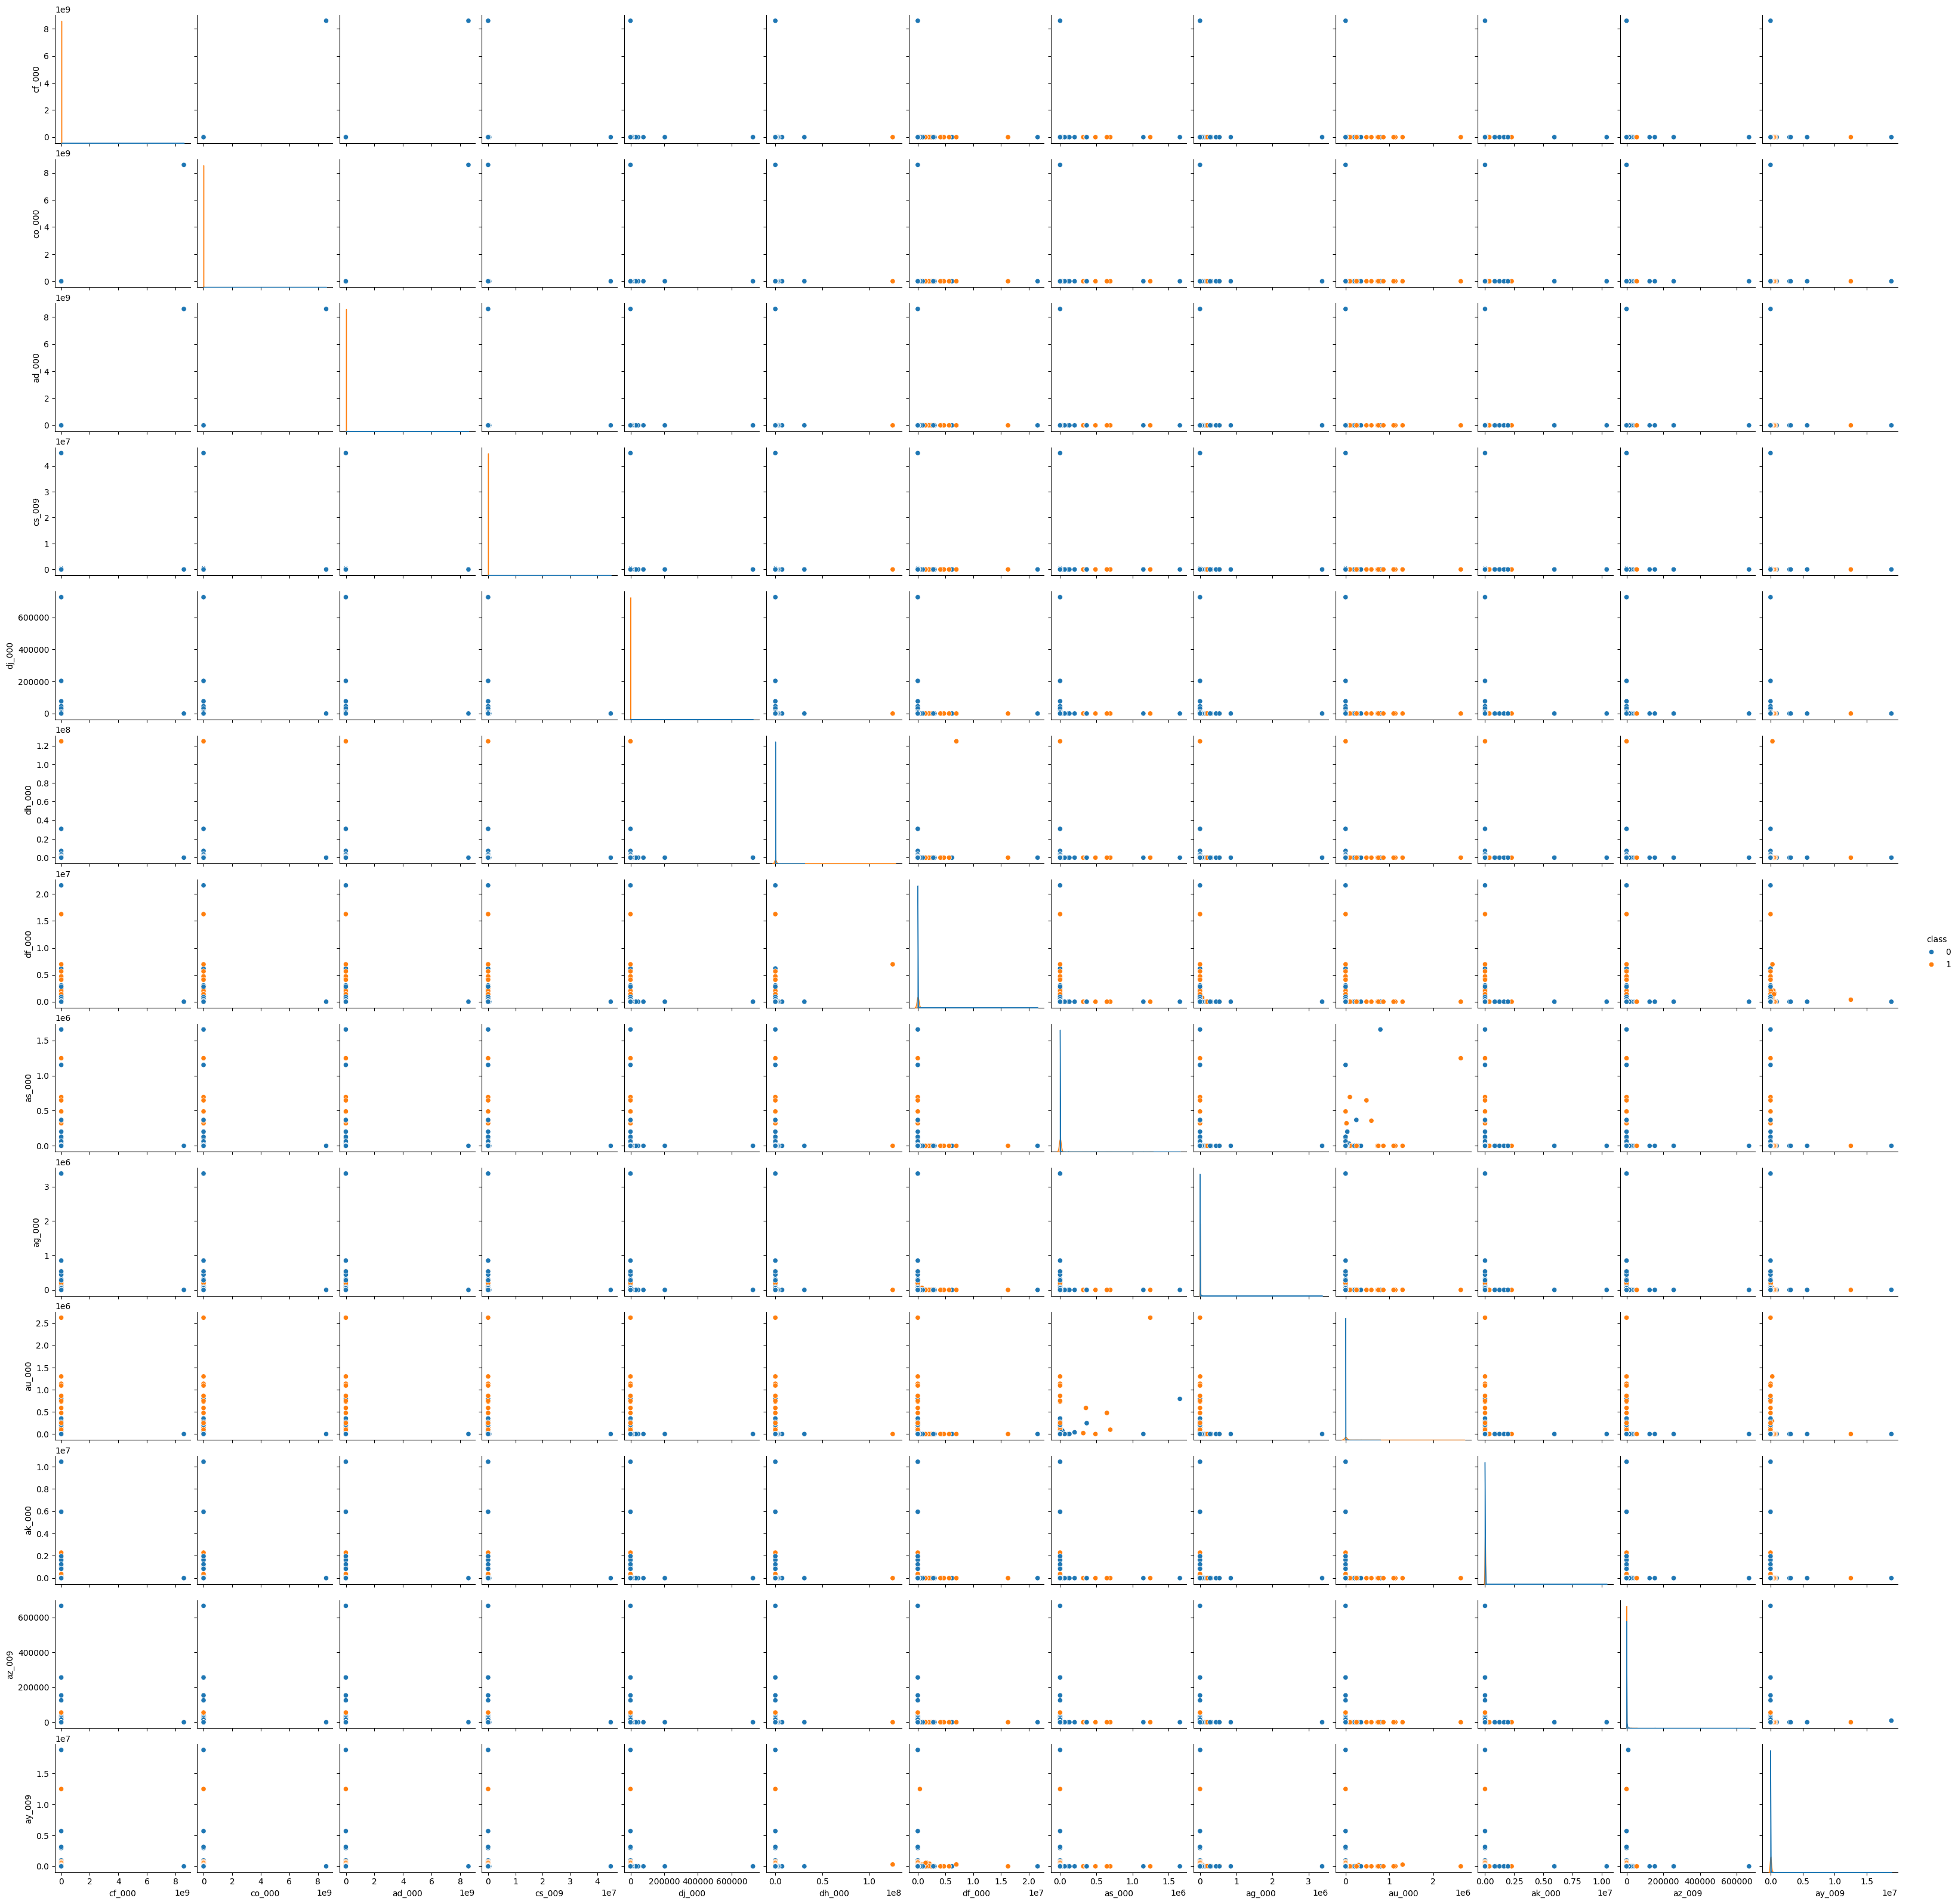

In [16]:
fig = plt.figure(figsize=(25,20))
_ = sns.pairplot(data=train_df_imputed[selected_features], hue='class')

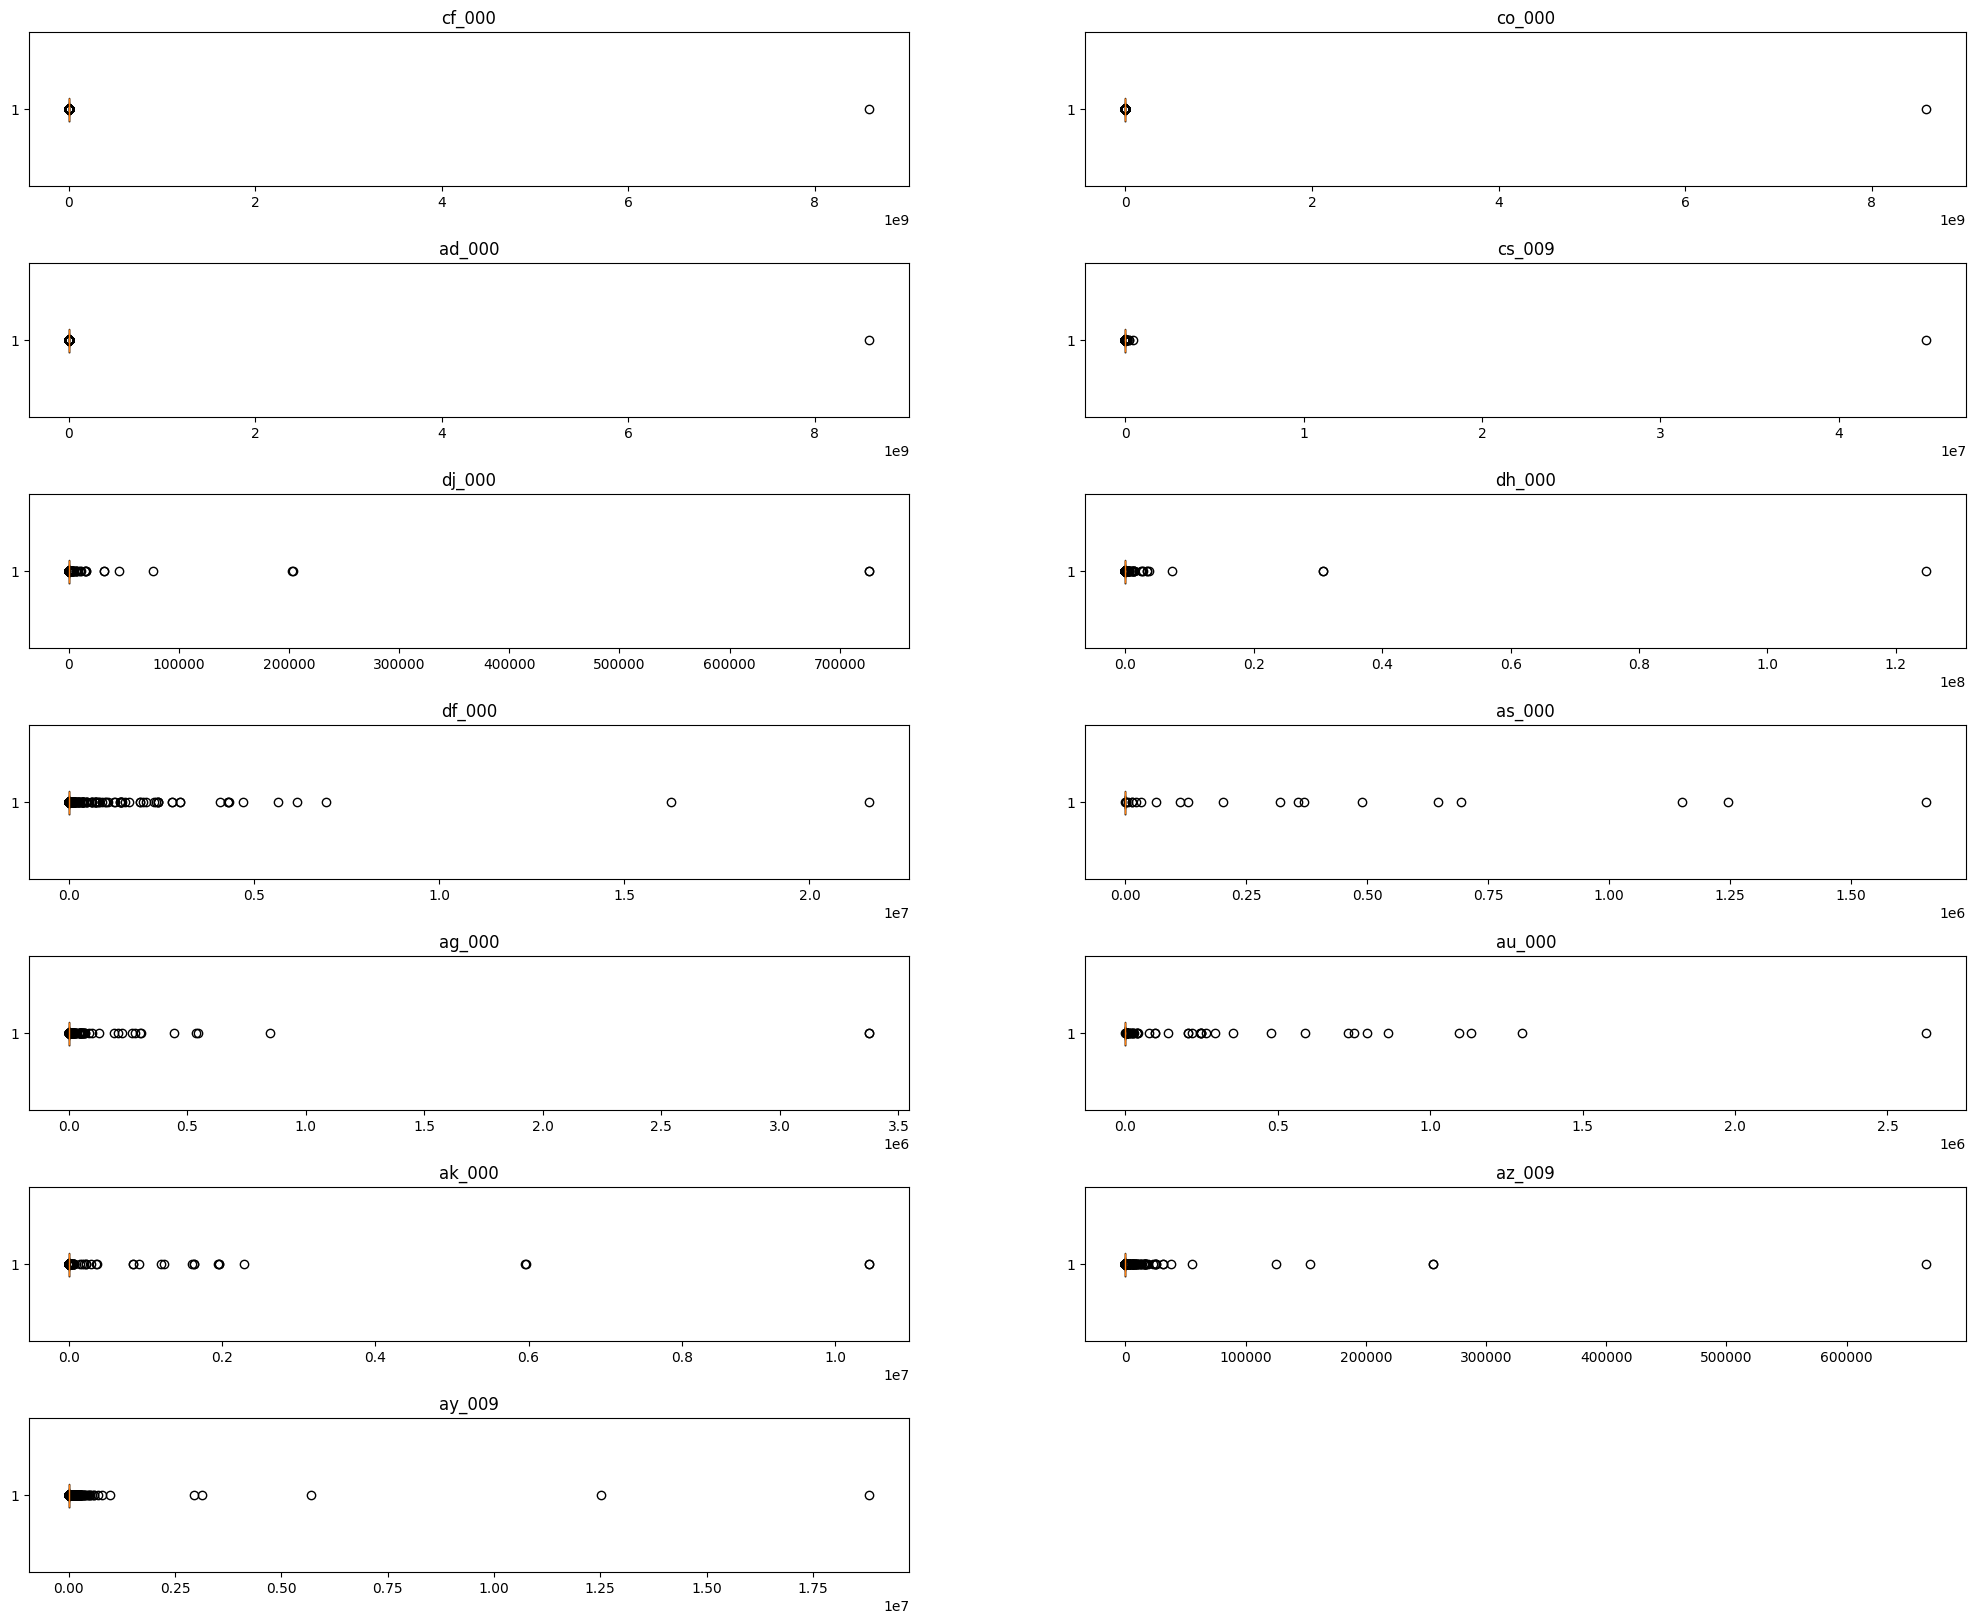

In [17]:
fig = plt.figure(figsize=(25,20))
selected_features.remove('class')
for i, feature in enumerate(selected_features):
    plt.subplot(7,2,i+1)
    plt.title(feature)
    plt.boxplot(X_train[feature], notch=None, vert=False, patch_artist=None, widths=None)
plt.subplots_adjust(hspace=0.5)

The observations from the scatter plots and boxplots are :   
* For the 'cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000' features, the positive class is  skewed towards 0 feature values while the negative class is spread out on the entire graph.
* For the 'dh_000', 'df_000', 'as_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009' features, the negative class is skewed towards 0 feature value while the positive class is spread out on the entire graph.   
* There are many outliers in each features with significantly high values hence, mean must not be used for imputation.   
* Since the values of those features is significantly high, it is difficult to make any conclusions from the scatter plot as it makes the entire data graph skewed to one side.

#### (v) Is this data set imbalanced?

In [18]:
count_train = y_train.value_counts()
count_test = y_test.value_counts()
print('Train Count : ', count_train)
print('Test Count : ', count_test)

Train Count :  class
0    59000
1     1000
Name: count, dtype: int64
Test Count :  class
0    15625
1      375
Name: count, dtype: int64


Since the ratio of samples in two classes is 59:1 for the train set and , we can conclude that the dataset is highly imbalanced

### (c) Train a random forest

In [19]:
model_rf = RandomForestClassifier(random_state=0, oob_score=True, n_jobs=-1)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
y_train_pred_rf = model_rf.predict(X_train)

y_pred_rf_probas = model_rf.predict_proba(X_test)
y_train_pred_rf_probas = model_rf.predict_proba(X_train)

# ridge_model = GridSearchCV(Ridge(), param_grid, cv=KFold(n_splits=7, random_state=1, shuffle=True), n_jobs=-1, scoring='neg_mean_squared_error')
# ridge_model.fit(X_train, y_train)

# ridge_y_pred = ridge_model.predict(X_test)

In [20]:
cm_rf = confusion_matrix(y_pred=y_pred_rf, y_true=y_test)
cm_rf_train = confusion_matrix(y_pred=y_train_pred_rf, y_true=y_train)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf_probas[:, 1])
fpr_rf_train, tpr_rf_train, thresholds_rf_train = roc_curve(y_train, y_train_pred_rf_probas[:, 1])
misclassification_rf = (cm_rf[0][1] + cm_rf[1][0]) / cm_rf.sum()
misclassification_rf_train = (cm_rf_train[0][1] + cm_rf_train[1][0]) / cm_rf_train.sum()

In [21]:
print('Confusion Matrix for Random Forest Test : \n', cm_rf, '\n')
print('Confusion Matrix for Random Forest Train : \n', cm_rf_train, '\n')
print('AUC for Random Forest Test : ', auc(fpr_rf, tpr_rf), '\n')
print('AUC for Random Forest Train : ', auc(fpr_rf_train, tpr_rf_train), '\n')
print('Misclassification for Test : ', misclassification_rf, '\n')
print('Misclassification for Train : ', misclassification_rf_train, '\n')
print('Out of Bag Error estimate : ', 1 - model_rf.oob_score_, '\n')
print('Test Error : ', 1-accuracy_score(y_test, y_pred_rf), '\n')

Confusion Matrix for Random Forest Test : 
 [[15610    15]
 [  103   272]] 

Confusion Matrix for Random Forest Train : 
 [[59000     0]
 [    0  1000]] 

AUC for Random Forest Test :  0.9943537493333334 

AUC for Random Forest Train :  1.0 

Misclassification for Test :  0.007375 

Misclassification for Train :  0.0 

Out of Bag Error estimate :  0.006166666666666654 

Test Error :  0.00737500000000002 



The difference between OOB and test error is very small i.e. only 0.001. The OOB error is smaller than the test error

<Axes: title={'center': 'Random Forest Train'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

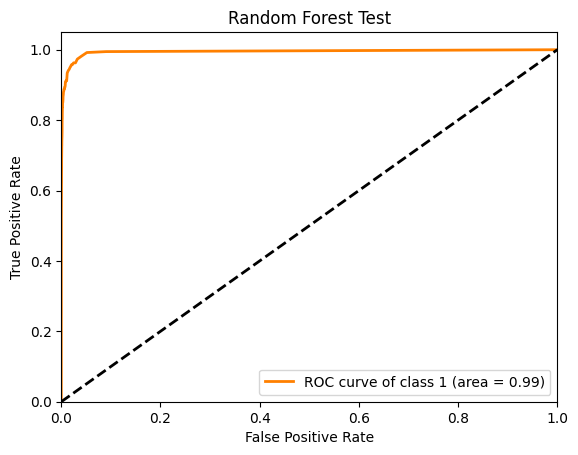

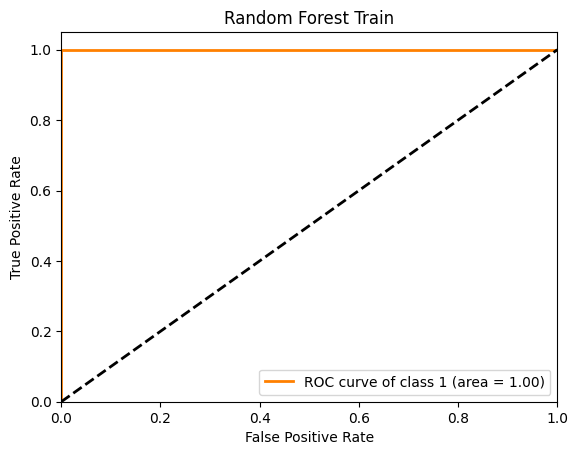

In [22]:
plot_roc(y_test, y_pred_rf_probas, title='Random Forest Test', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')
plot_roc(y_train, y_train_pred_rf_probas, title='Random Forest Train', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')
# RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=auc(fpr_rf, tpr_rf), estimator_name='Random Forest Test').plot()
# RocCurveDisplay(fpr=fpr_rf_train, tpr=tpr_rf_train, roc_auc=auc(fpr_rf_train, tpr_rf_train), estimator_name='Random Forest Train').plot()

### (d) Research class imbalance in random forest

https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf

In random forest, we can address imbalance by one of the two ways :   
* By using the class_weight as balanced which assigns weights to different class and in its absence, all the classes are assigned the same weights = 1
* By using BalancedRandomForestClassifier which randomly undersamples each bootstrap sample to handle the imabalance.

In [23]:
model_rf_balanced = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight='balanced')
model_rf_balanced.fit(X_train, y_train)
y_pred_rf_balanced = model_rf_balanced.predict(X_test)
y_train_pred_rf_balanced = model_rf_balanced.predict(X_train)
y_pred_rf_probas_balanced = model_rf_balanced.predict_proba(X_test)
y_train_pred_rf_probas_balanced = model_rf_balanced.predict_proba(X_train)

In [24]:
cm_rf_balanced = confusion_matrix(y_pred=y_pred_rf_balanced, y_true=y_test)
cm_rf_balanced_train = confusion_matrix(y_pred=y_train_pred_rf_balanced, y_true=y_train)
fpr_rf_balanced, tpr_rf_balanced, thresholds_rf_balanced = roc_curve(y_test, y_pred_rf_probas_balanced[:, 1])
fpr_rf_balanced_train, tpr_rf_balanced_train, thresholds_rf_balanced_train = roc_curve(y_train, y_train_pred_rf_probas_balanced[:, 1])
misclassification_rf_balanced = (cm_rf_balanced[0][1] + cm_rf_balanced[1][0])/cm_rf_balanced.sum()
misclassification_rf_balanced_train = (cm_rf_balanced_train[0][1] + cm_rf_balanced_train[1][0])/cm_rf_balanced_train.sum()

In [25]:
print('Confusion Matrix for Random Forest(Balanced) Test : \n', cm_rf_balanced, '\n')
print('Confusion Matrix for Random Forest(Balanced) Train : \n', cm_rf_balanced_train, '\n')
print('AUC for Random Forest (Balanced) Test : ', auc(fpr_rf_balanced, tpr_rf_balanced), '\n')
print('AUC for Random Forest (Balanced) Train : ', auc(fpr_rf_balanced_train, tpr_rf_balanced_train), '\n')
print('Misclassification for Random Forest(Balanced) Test : ', misclassification_rf_balanced, '\n')
print('Misclassification for Random Forest(Balanced) Train : ', misclassification_rf_balanced_train, '\n')
print('Out of Bag Error Random Forest(Balanced) estimate : ', 1 - model_rf_balanced.oob_score_, '\n')
print('Test Error for Random Forest(Balanced): ', 1-accuracy_score(y_test, y_pred_rf_balanced), '\n')

Confusion Matrix for Random Forest(Balanced) Test : 
 [[15611    14]
 [  160   215]] 

Confusion Matrix for Random Forest(Balanced) Train : 
 [[59000     0]
 [    1   999]] 

AUC for Random Forest (Balanced) Test :  0.991943936 

AUC for Random Forest (Balanced) Train :  1.0 

Misclassification for Random Forest(Balanced) Test :  0.010875 

Misclassification for Random Forest(Balanced) Train :  1.6666666666666667e-05 

Out of Bag Error Random Forest(Balanced) estimate :  0.008199999999999985 

Test Error for Random Forest(Balanced):  0.010874999999999968 



For Balanced Random Forest as well, the Out of Bag Error is less than the test error by 0.002

<Axes: title={'center': 'Random Forest Train(Balanced)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

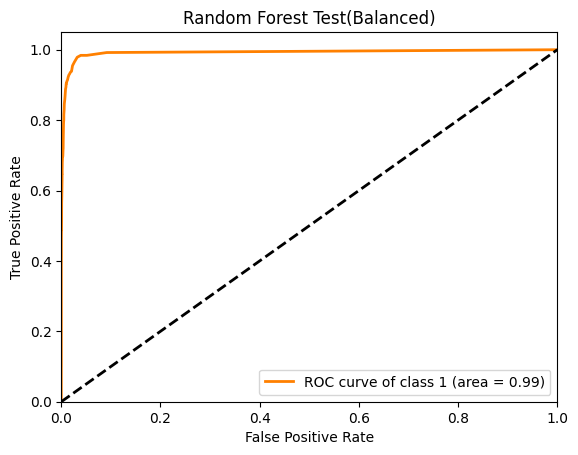

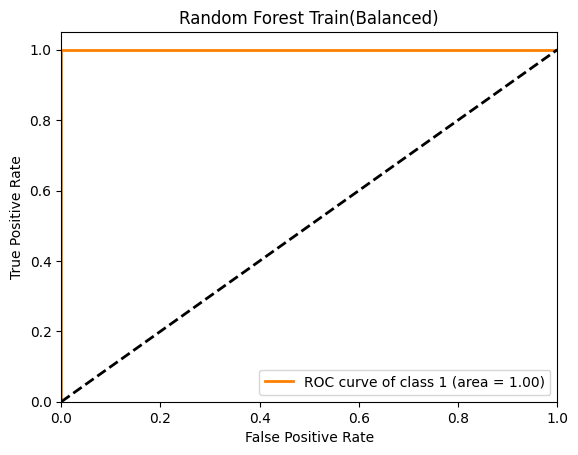

In [26]:
plot_roc(y_test, y_pred_rf_probas_balanced, title='Random Forest Test(Balanced)', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')
plot_roc(y_train, y_train_pred_rf_probas_balanced, title='Random Forest Train(Balanced)', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')
# RocCurveDisplay(fpr=fpr_rf_balanced, tpr=tpr_rf_balanced, roc_auc=auc(fpr_rf_balanced, tpr_rf_balanced), estimator_name='Random Forest(Balanced) Test').plot()
# RocCurveDisplay(fpr=fpr_rf_balanced_train, tpr=tpr_rf_balanced_train, roc_auc=auc(fpr_rf_balanced_train, tpr_rf_balanced_train), estimator_name='Random Forest(Balanced) Train').plot()

In [40]:
rf_metrics = [
    ['AUC (Test)', auc(fpr_rf, tpr_rf), auc(fpr_rf_balanced, tpr_rf_balanced)],
    ['AUC (Train)', auc(fpr_rf_train, tpr_rf_train), auc(fpr_rf_balanced_train, tpr_rf_balanced_train)],
    ['Misclassification (Test)', misclassification_rf, misclassification_rf_balanced],
    ['Misclassification (Train)', misclassification_rf_train, misclassification_rf_balanced_train],
    ['Out of Bag Error', 1 - model_rf.oob_score_, 1 - model_rf_balanced.oob_score_],
    ['Test Error', 1-accuracy_score(y_test, y_pred_rf), 1-accuracy_score(y_test, y_pred_rf_balanced)],
    ['Confusion Matrix (Test)', np.array2string(np.array(cm_rf)), np.array2string(np.array(cm_rf_balanced))],
]

print(tabulate(rf_metrics, headers=['Metric', 'Random Forest', 'Random Forest(Balanced)'], tablefmt='simple'))

Metric                     Random Forest         Random Forest(Balanced)
-------------------------  --------------------  -------------------------
AUC (Test)                 0.9943537493333334    0.991943936
AUC (Train)                1.0                   1.0
Misclassification (Test)   0.007375              0.010875
Misclassification (Train)  0.0                   1.6666666666666667e-05
Out of Bag Error           0.006166666666666654  0.008199999999999985
Test Error                 0.00737500000000002   0.010874999999999968
Confusion Matrix (Test)    [[15610    15]        [[15611    14]
                            [  103   272]]        [  160   215]]


On balancing in the Random Forest, we notice that the test error increases, and so does the misclassification. It is because once we add the balancing, it gives more importance or significance to the lesser class to compensate to less number of samples and thus, the errors increase. While the number of false negatives increases, the number of true positives decreases

### (e) XGBoost and Model Trees

In [41]:
print(y_test.value_counts())

class
0    15625
1      375
Name: count, dtype: int64


In [42]:
param_grid = {
    'alpha': [10**i for i in range(-10, 10)]
}
xgb = XGBClassifier()
model_xgb = GridSearchCV(xgb, param_grid, n_jobs=-1, scoring='f1', cv = 5)
model_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                   0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000, 1000000, 10000000, 100000000,
                                   1000000000]},
             scoring='f1')

In [43]:
y_pred_xgb = model_xgb.predict(X_test)
y_train_pred_xgb = model_xgb.predict(X_train)
y_pred_xgb_probas = model_xgb.predict_proba(X_test)
y_train_pred_xgb_probas = model_xgb.predict_proba(X_train)

In [44]:
cm_xgb = confusion_matrix(y_pred=y_pred_xgb, y_true=y_test)
cm_xgb_train = confusion_matrix(y_pred=y_train_pred_xgb, y_true=y_train)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_probas[:, 1])
fpr_xgb_train, tpr_xgb_train, thresholds_xgb_train = roc_curve(y_train, y_train_pred_xgb_probas[:, 1])

In [45]:
print('Regularization Parameter : ', model_xgb.best_params_)

Regularization Parameter :  {'alpha': 0.0001}


In [46]:
print('Confusion Matrix for XGBoost Tree Test: \n', cm_xgb, '\n')
print('Confusion Matrix for XGBoost Tree Train: \n', cm_xgb_train, '\n')
print('AUC for XGBoost Test: ', auc(fpr_xgb, tpr_xgb), '\n')
print('AUC for XGBoost Train: ', auc(fpr_xgb_train, tpr_xgb_train), '\n')
print('Test Error for XGBoost: ', 1-accuracy_score(y_test, y_pred_xgb), '\n')
print('Cross Validation Error for XGBoost: ', 1-model_xgb.best_score_, '\n')

Confusion Matrix for XGBoost Tree Test: 
 [[15610    15]
 [   82   293]] 

Confusion Matrix for XGBoost Tree Train: 
 [[59000     0]
 [    1   999]] 

AUC for XGBoost Test:  0.994820096 

AUC for XGBoost Train:  0.9999993898305085 

Test Error for XGBoost:  0.006062499999999971 

Cross Validation Error for XGBoost:  0.17239330392026186 



<Axes: title={'center': 'XGBoost Train'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

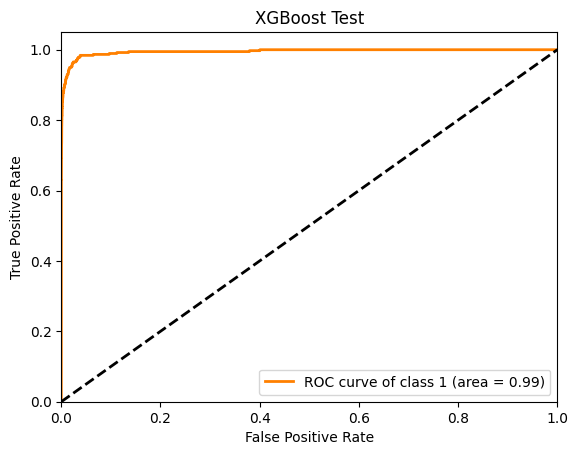

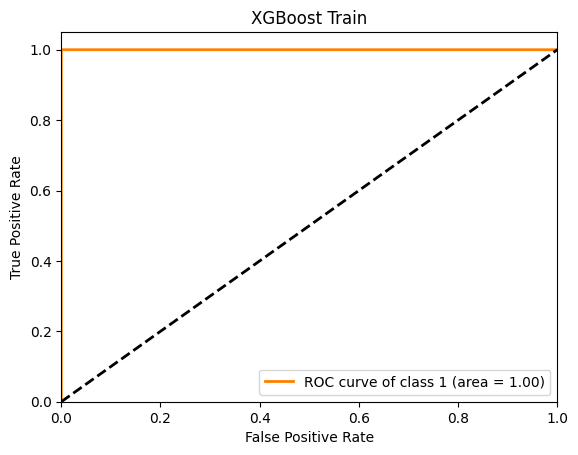

In [47]:
plot_roc(y_test, y_pred_xgb_probas, title='XGBoost Test', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')
plot_roc(y_train, y_train_pred_xgb_probas, title='XGBoost Train', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')
# RocCurveDisplay(fpr=fpr_xgb, tpr=tpr_xgb, roc_auc=auc(fpr_xgb, tpr_xgb), estimator_name='XGBoost Test').plot()
# RocCurveDisplay(fpr=fpr_xgb_train, tpr=tpr_xgb_train, roc_auc=auc(fpr_xgb_train, tpr_xgb_train), estimator_name='XGBoost Train').plot()

### (f) Use SMOTE to pre-process your data

In [48]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                # ['scaler', MinMaxScaler()],
                                ['classifier', XGBClassifier()]])

param_grid = {
    'classifier__alpha': [10**i for i in range(-10, 10)]
}


model_xgb_smote = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1)

model_xgb_smote.fit(X_train, y_train)
cv_score = model_xgb_smote.best_score_
test_score = model_xgb_smote.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8045873518685154
Test score: 0.8521031207598372


In [49]:
y_pred_xgb_smote = model_xgb_smote.predict(X_test)
y_train_pred_xgb_smote = model_xgb_smote.predict(X_train)

y_pred_xgb_smote_probas = model_xgb_smote.predict_proba(X_test)
y_train_pred_xgb_smote_probas = model_xgb_smote.predict_proba(X_train)

In [50]:
cm_xgb_smote = confusion_matrix(y_pred=y_pred_xgb_smote, y_true=y_test)
cm_xgb_smote_train = confusion_matrix(y_pred=y_train_pred_xgb_smote, y_true=y_train)
fpr_xgb_smote, tpr_xgb_smote, thresholds_xgb_smote = roc_curve(y_test, y_pred_xgb_smote_probas[:, 1])
fpr_xgb_smote_train, tpr_xgb_smote_train, thresholds_xgb_smote_train = roc_curve(y_train, y_train_pred_xgb_smote_probas[:, 1])

In [51]:
print('Confusion Matrix for XGBoost(SMOTE) Tree Test: \n', cm_xgb_smote, '\n')
print('Confusion Matrix for XGBoost(SMOTE) Tree Train: \n', cm_xgb_smote_train, '\n')
print('AUC for XGBoost(SMOTE) Test: ', auc(fpr_xgb_smote, tpr_xgb_smote), '\n')
print('AUC for XGBoost(SMOTE) Train: ', auc(fpr_xgb_smote_train, tpr_xgb_smote_train), '\n')
print('Test Error for XGBoost(SMOTE): ', 1-accuracy_score(y_test, y_pred_xgb_smote), '\n')
print('Cross Validation Error for XGBoost(SMOTE): ', 1-model_xgb_smote.best_score_, '\n')

Confusion Matrix for XGBoost(SMOTE) Tree Test: 
 [[15577    48]
 [   61   314]] 

Confusion Matrix for XGBoost(SMOTE) Tree Train: 
 [[59000     0]
 [    1   999]] 

AUC for XGBoost(SMOTE) Test:  0.9947112106666667 

AUC for XGBoost(SMOTE) Train:  0.9999869661016949 

Test Error for XGBoost(SMOTE):  0.006812499999999999 

Cross Validation Error for XGBoost(SMOTE):  0.19541264813148462 



<Axes: title={'center': 'XGBoost Train(SMOTE)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

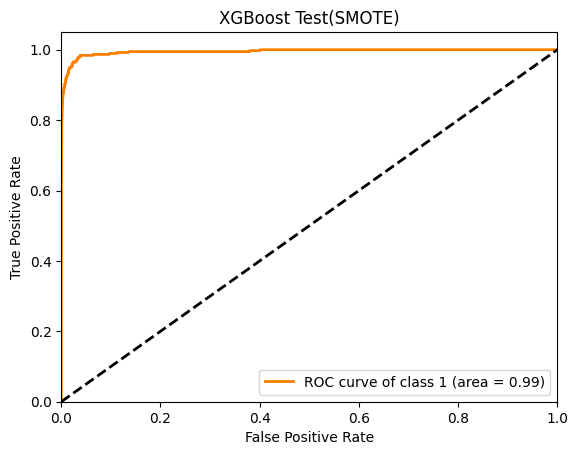

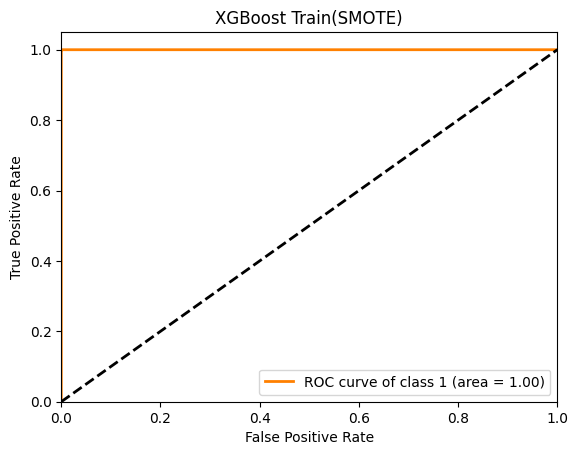

In [52]:
plot_roc(y_test, y_pred_xgb_probas, title='XGBoost Test(SMOTE)', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')
plot_roc(y_train, y_train_pred_xgb_probas, title='XGBoost Train(SMOTE)', plot_macro=False, plot_micro=False, classes_to_plot=[1], cmap='autumn')

In [56]:
xgb_metrics = [
    ['AUC (Test)', auc(fpr_xgb, tpr_xgb), auc(fpr_xgb_smote, tpr_xgb_smote)],
    ['AUC (Train)', auc(fpr_xgb_train, tpr_xgb_train), auc(fpr_xgb_smote_train, tpr_xgb_smote_train)],
    ['Cross Validation Error', 1-model_xgb.best_score_, 1-model_xgb_smote.best_score_],
    ['Test Error', 1-accuracy_score(y_test, y_pred_xgb), 1-accuracy_score(y_test, y_pred_xgb_smote)],
    ['Confusion Matrix (Test)', np.array2string(np.array(cm_xgb)), np.array2string(np.array(cm_xgb_smote))]
]
print(tabulate(xgb_metrics, headers=['Metric', 'XGBoost', 'XGBoost(SMOTE)']))

Metric                   XGBoost               XGBoost(SMOTE)
-----------------------  --------------------  --------------------
AUC (Test)               0.994820096           0.9947112106666667
AUC (Train)              0.9999993898305085    0.9999869661016949
Cross Validation Error   0.17239330392026186   0.19541264813148462
Test Error               0.006062499999999971  0.006812499999999999
Confusion Matrix (Test)  [[15610    15]        [[15577    48]
                          [   82   293]]        [   61   314]]


Using SMOTE, we observe a decrease in FNR and increase in FPR which overall increased the test error, but at the cost of increasing FPR, we significantly decrease FNR which is a rarer class, thus SMOTE gives good results

## 2. ISLR 6.6.3

* __a. It steadily descreases__ : As we increase s from 0, since we are minimizing the training RSS, the value keeps dropping until s becomes big enough for $\beta$ to satisfy the least squares solution. Once it reaches the least squares solution, the RSS stops decreasing.  
   
* __b. Decrease initially, and then eventually start increasing in a U shape__ : As we start from 0, we essentially have the null model, and the RSS keeps decreasing as we move towards the best solution for test set. Eventually, it starts increasing again as with an increase in flexibility of the model, it starts to overfit   
   
* __c. It steadily increases__ : With an increase in s, the flexibility of the model also increases, thus meaning that the variance also increases. Once the s is large enough for the $\beta$ to be the least squares solution, it stops increasing   
    
* __d. It steadily increases__ : The reasoning is similar to part c. With an increase in s, the flexibility of the model increases, the bias deacreases and once the s is large enough for the $\beta$ to be the least squares solution, it stops decreasing. We can also infer that from the relationship between Bias and Variance (Bias-Variance trade Off)   
   
* __e. Remains constant__ : Since the value of irreducible error is in no way correlated to s or the flexibility of the model, it remains constant. It essentially specifies the unmeasured change in Y that cannot be explained by the variables in X.

## 3. ISLR 6.6.5

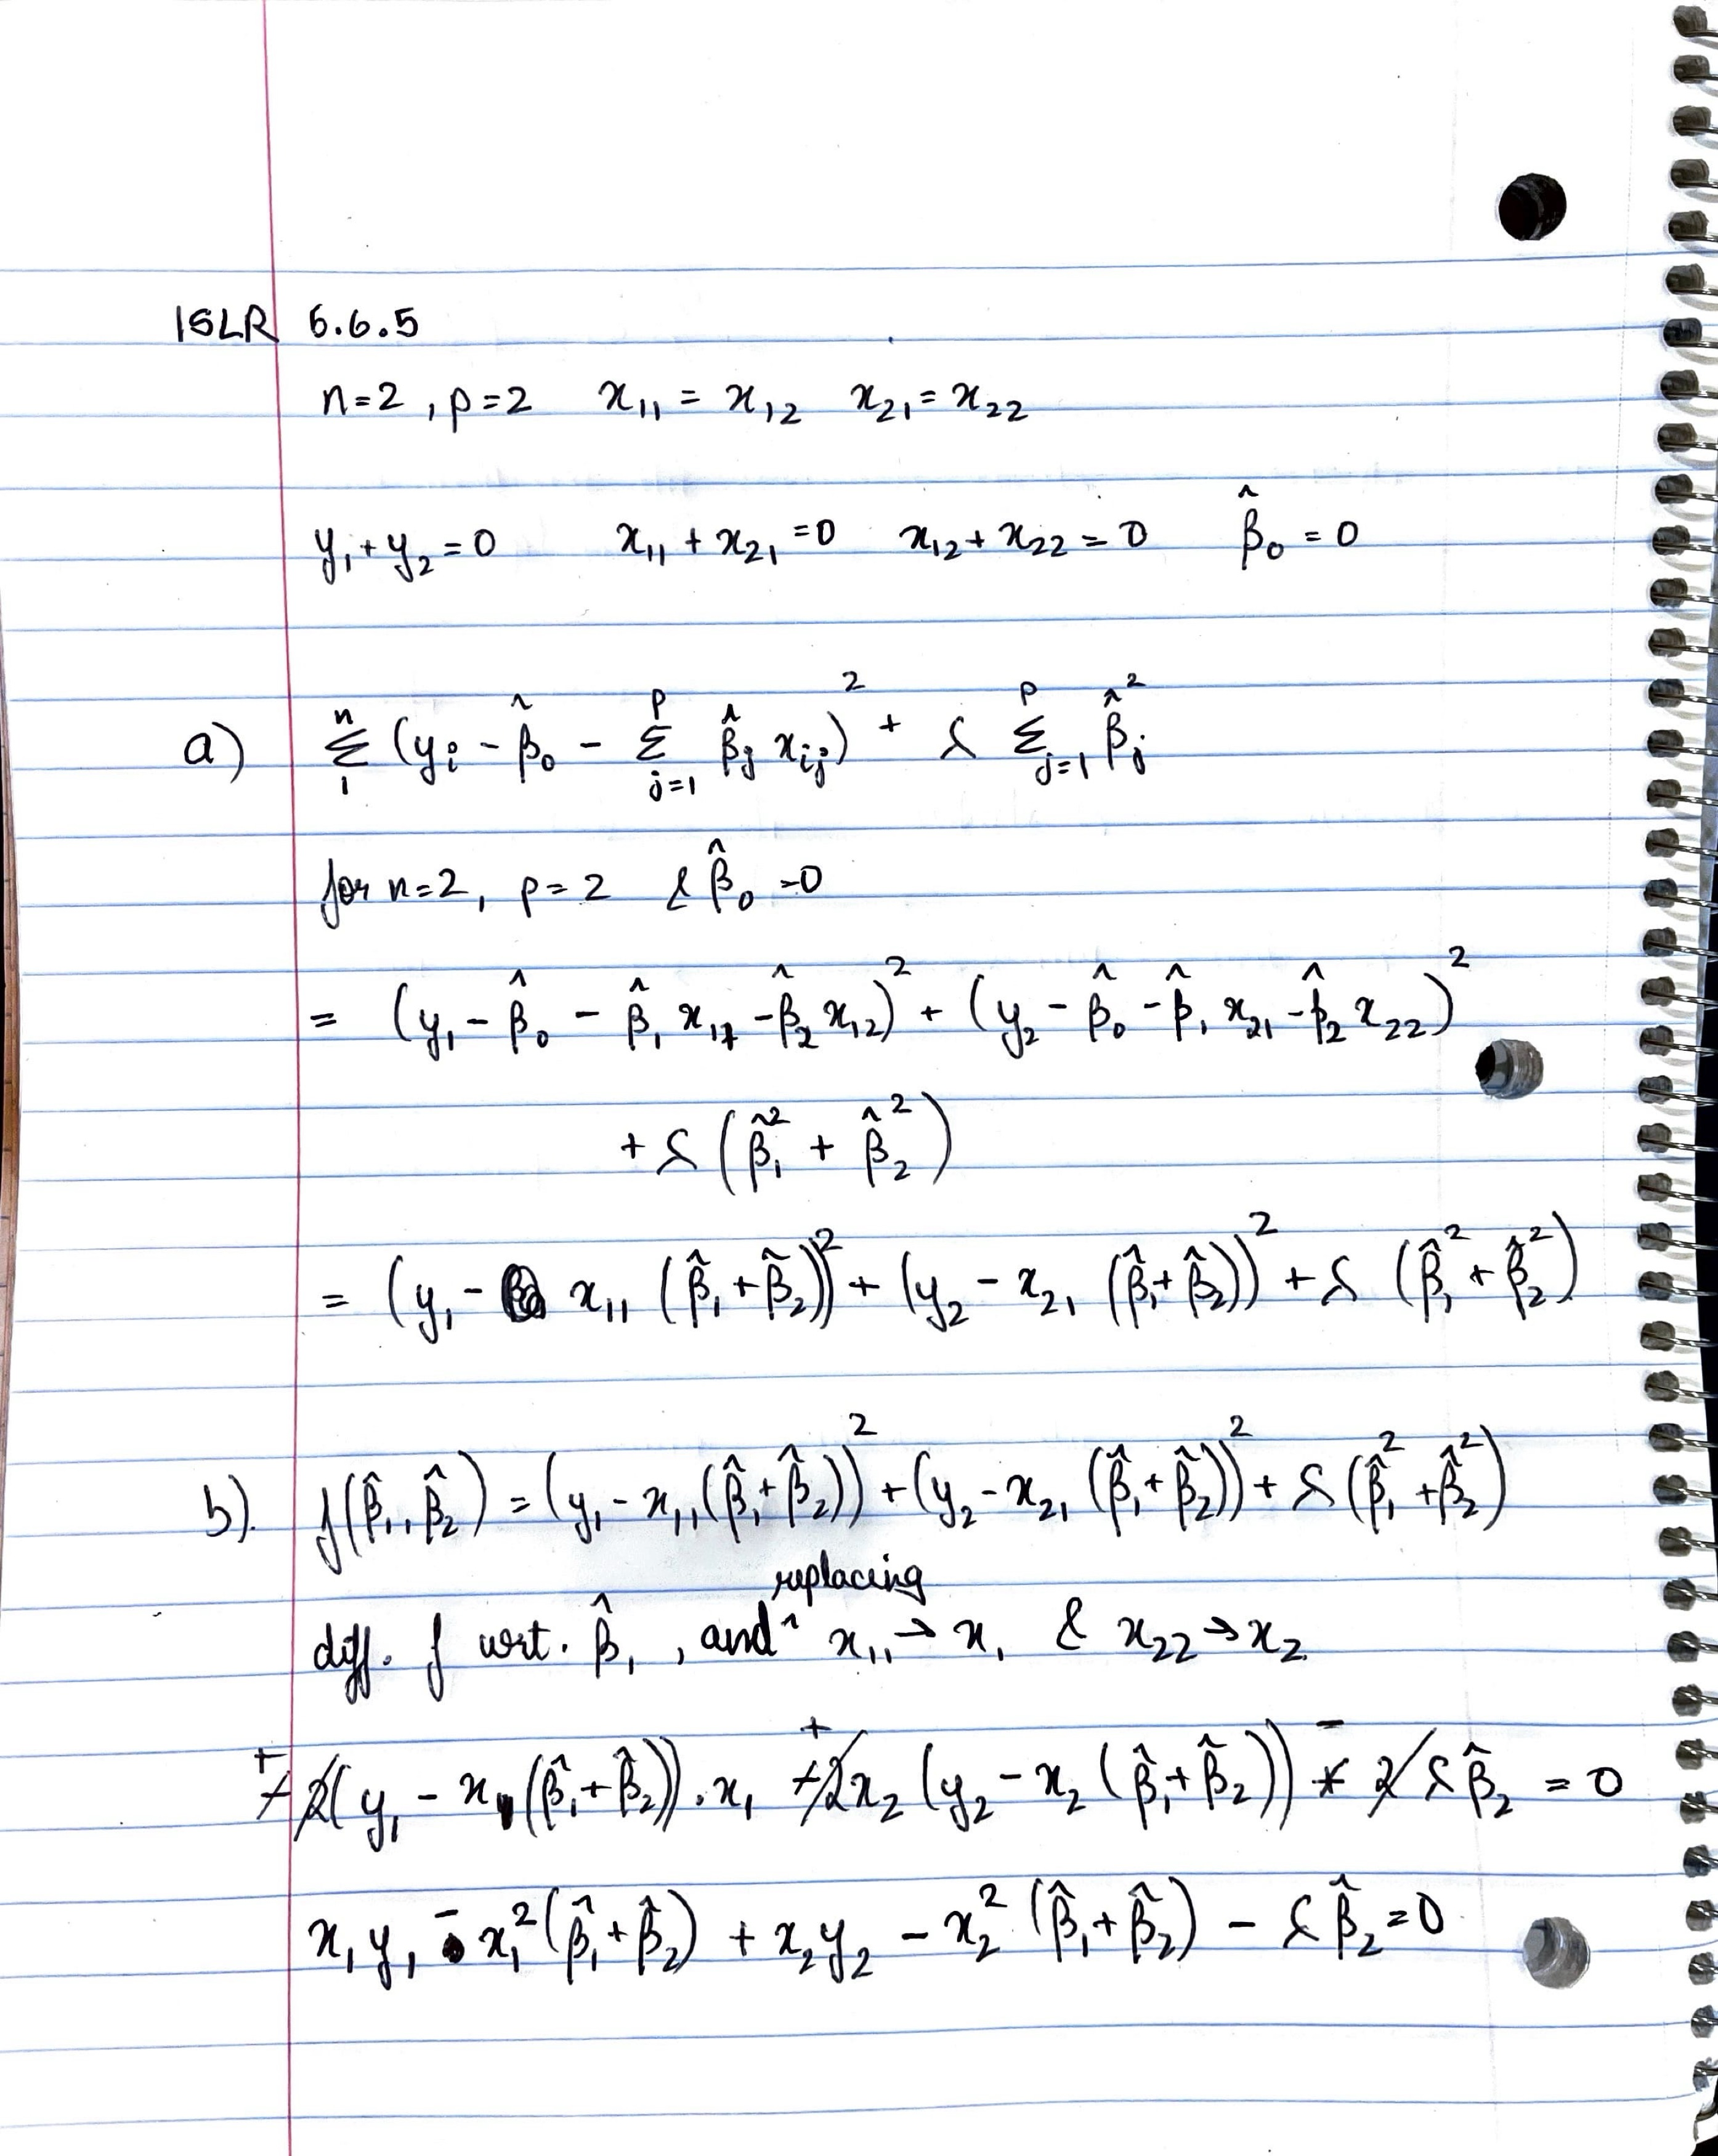 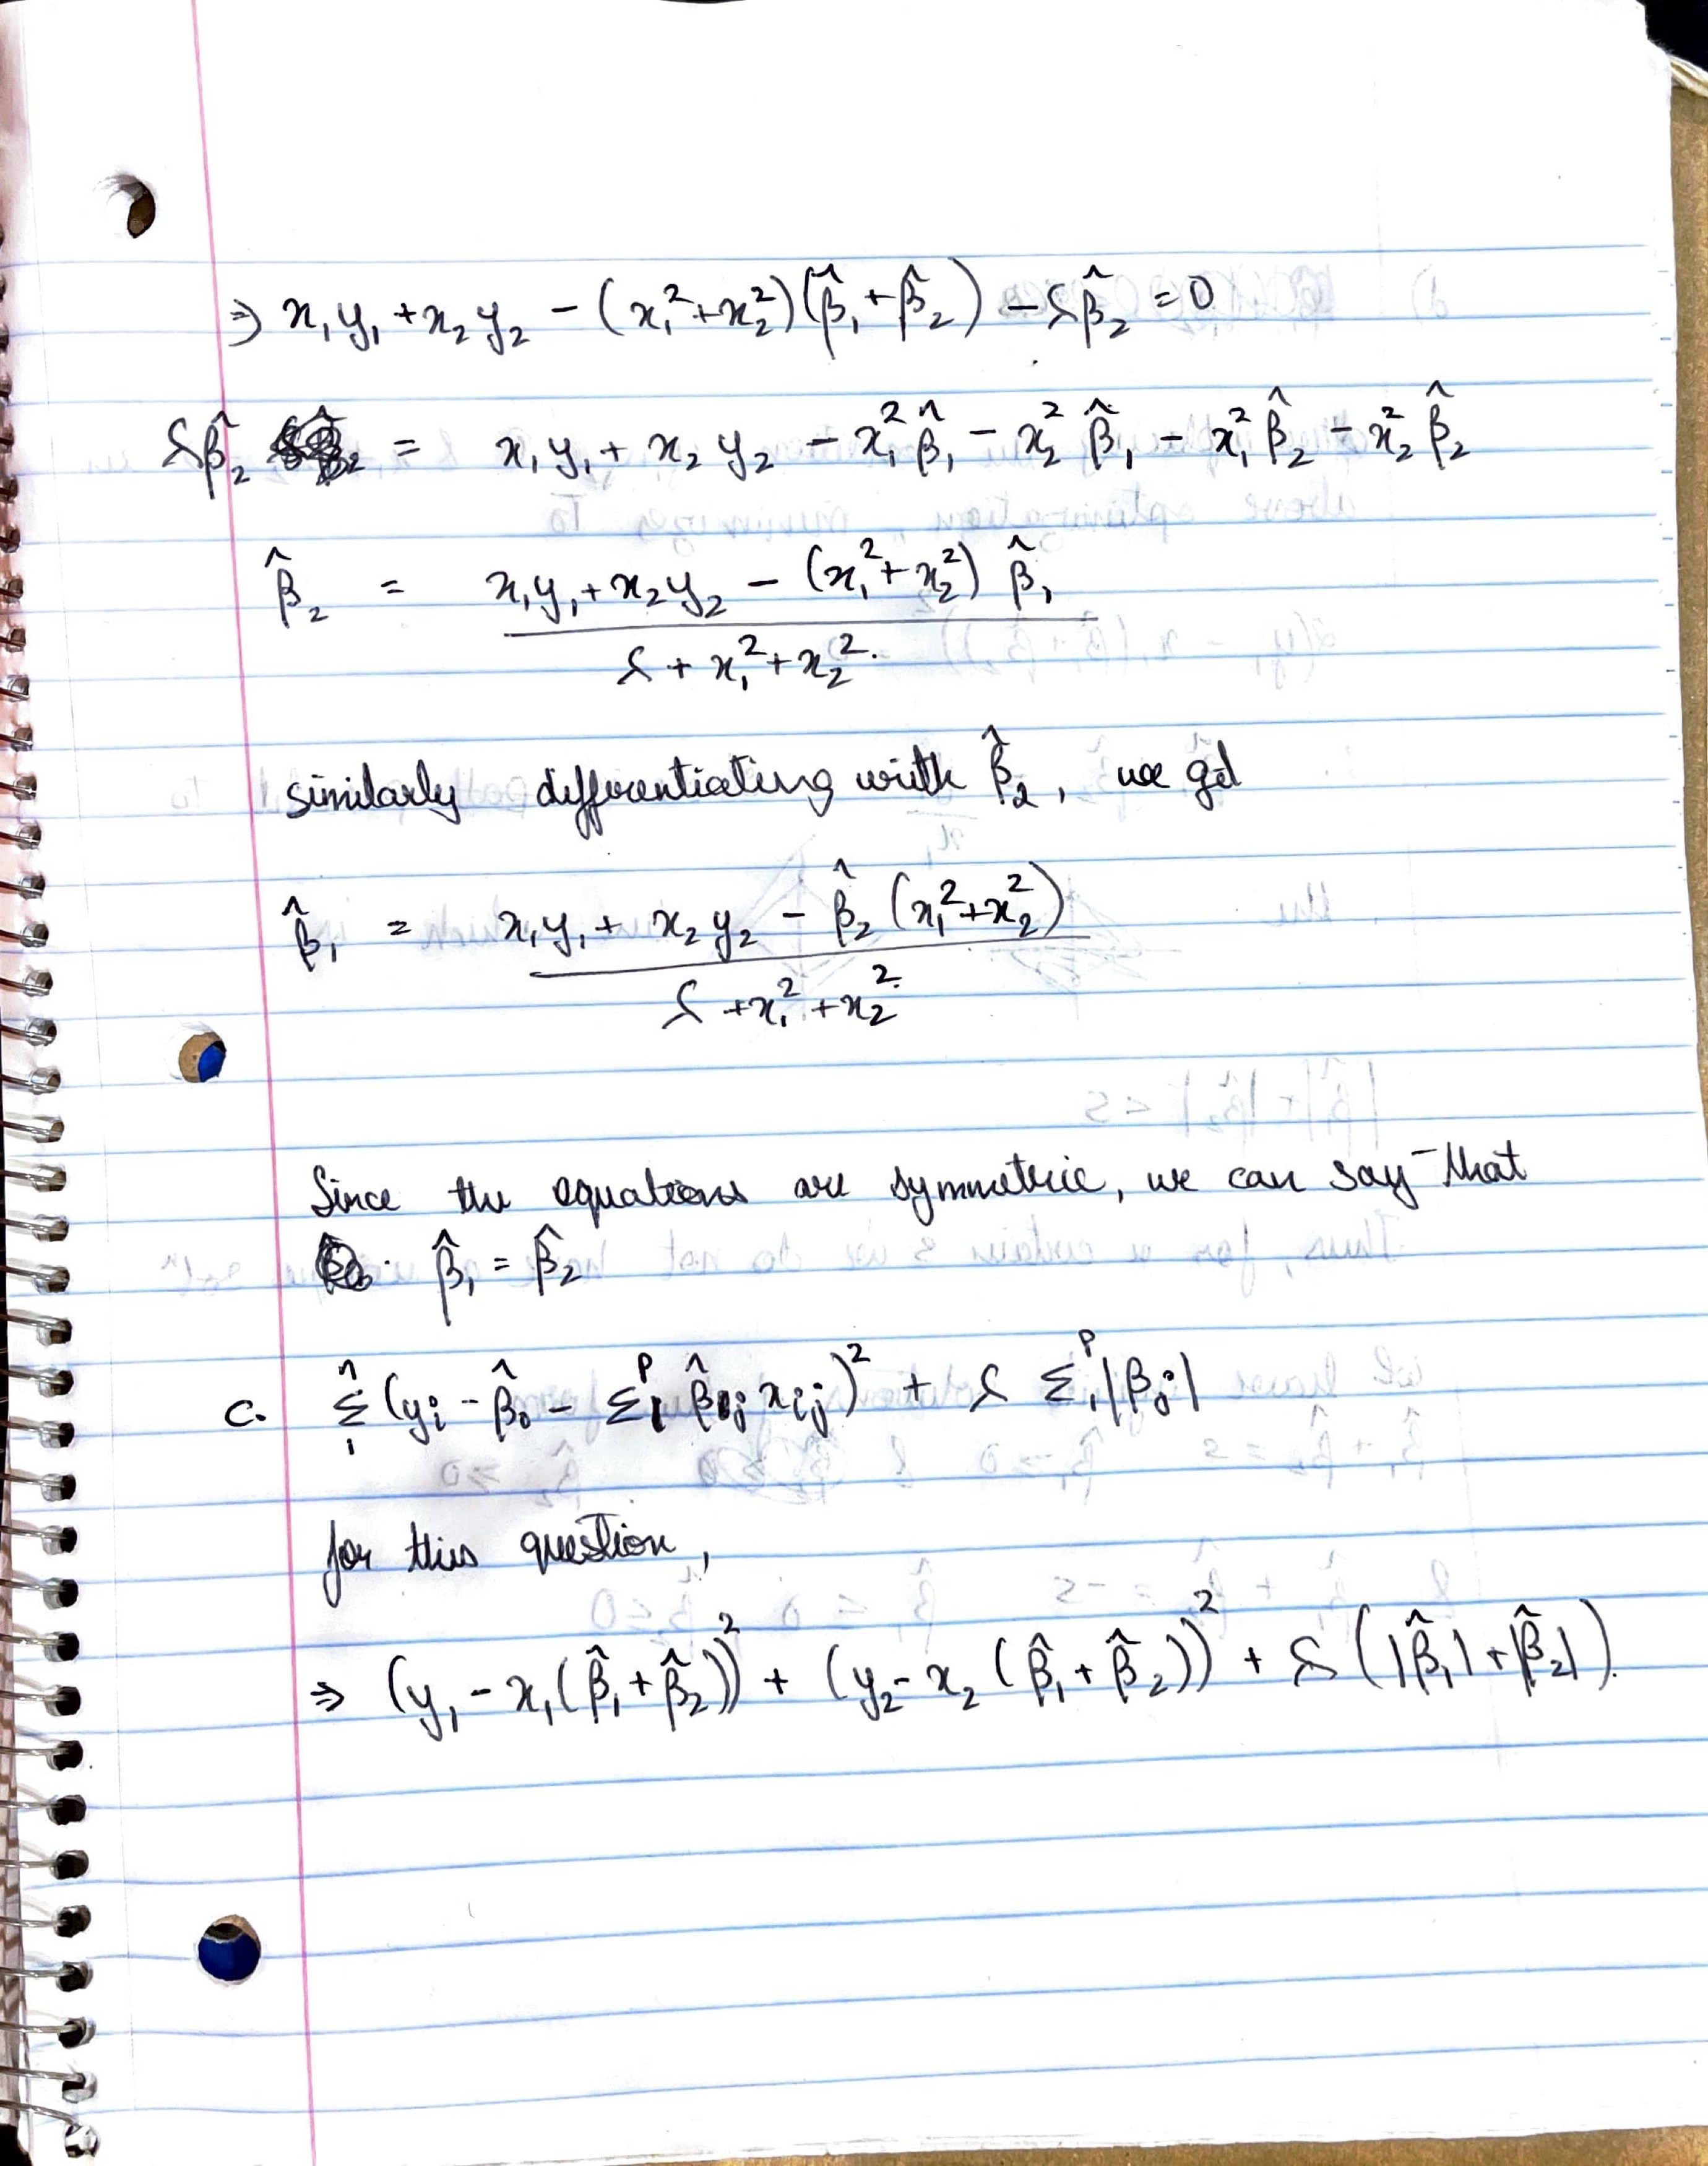 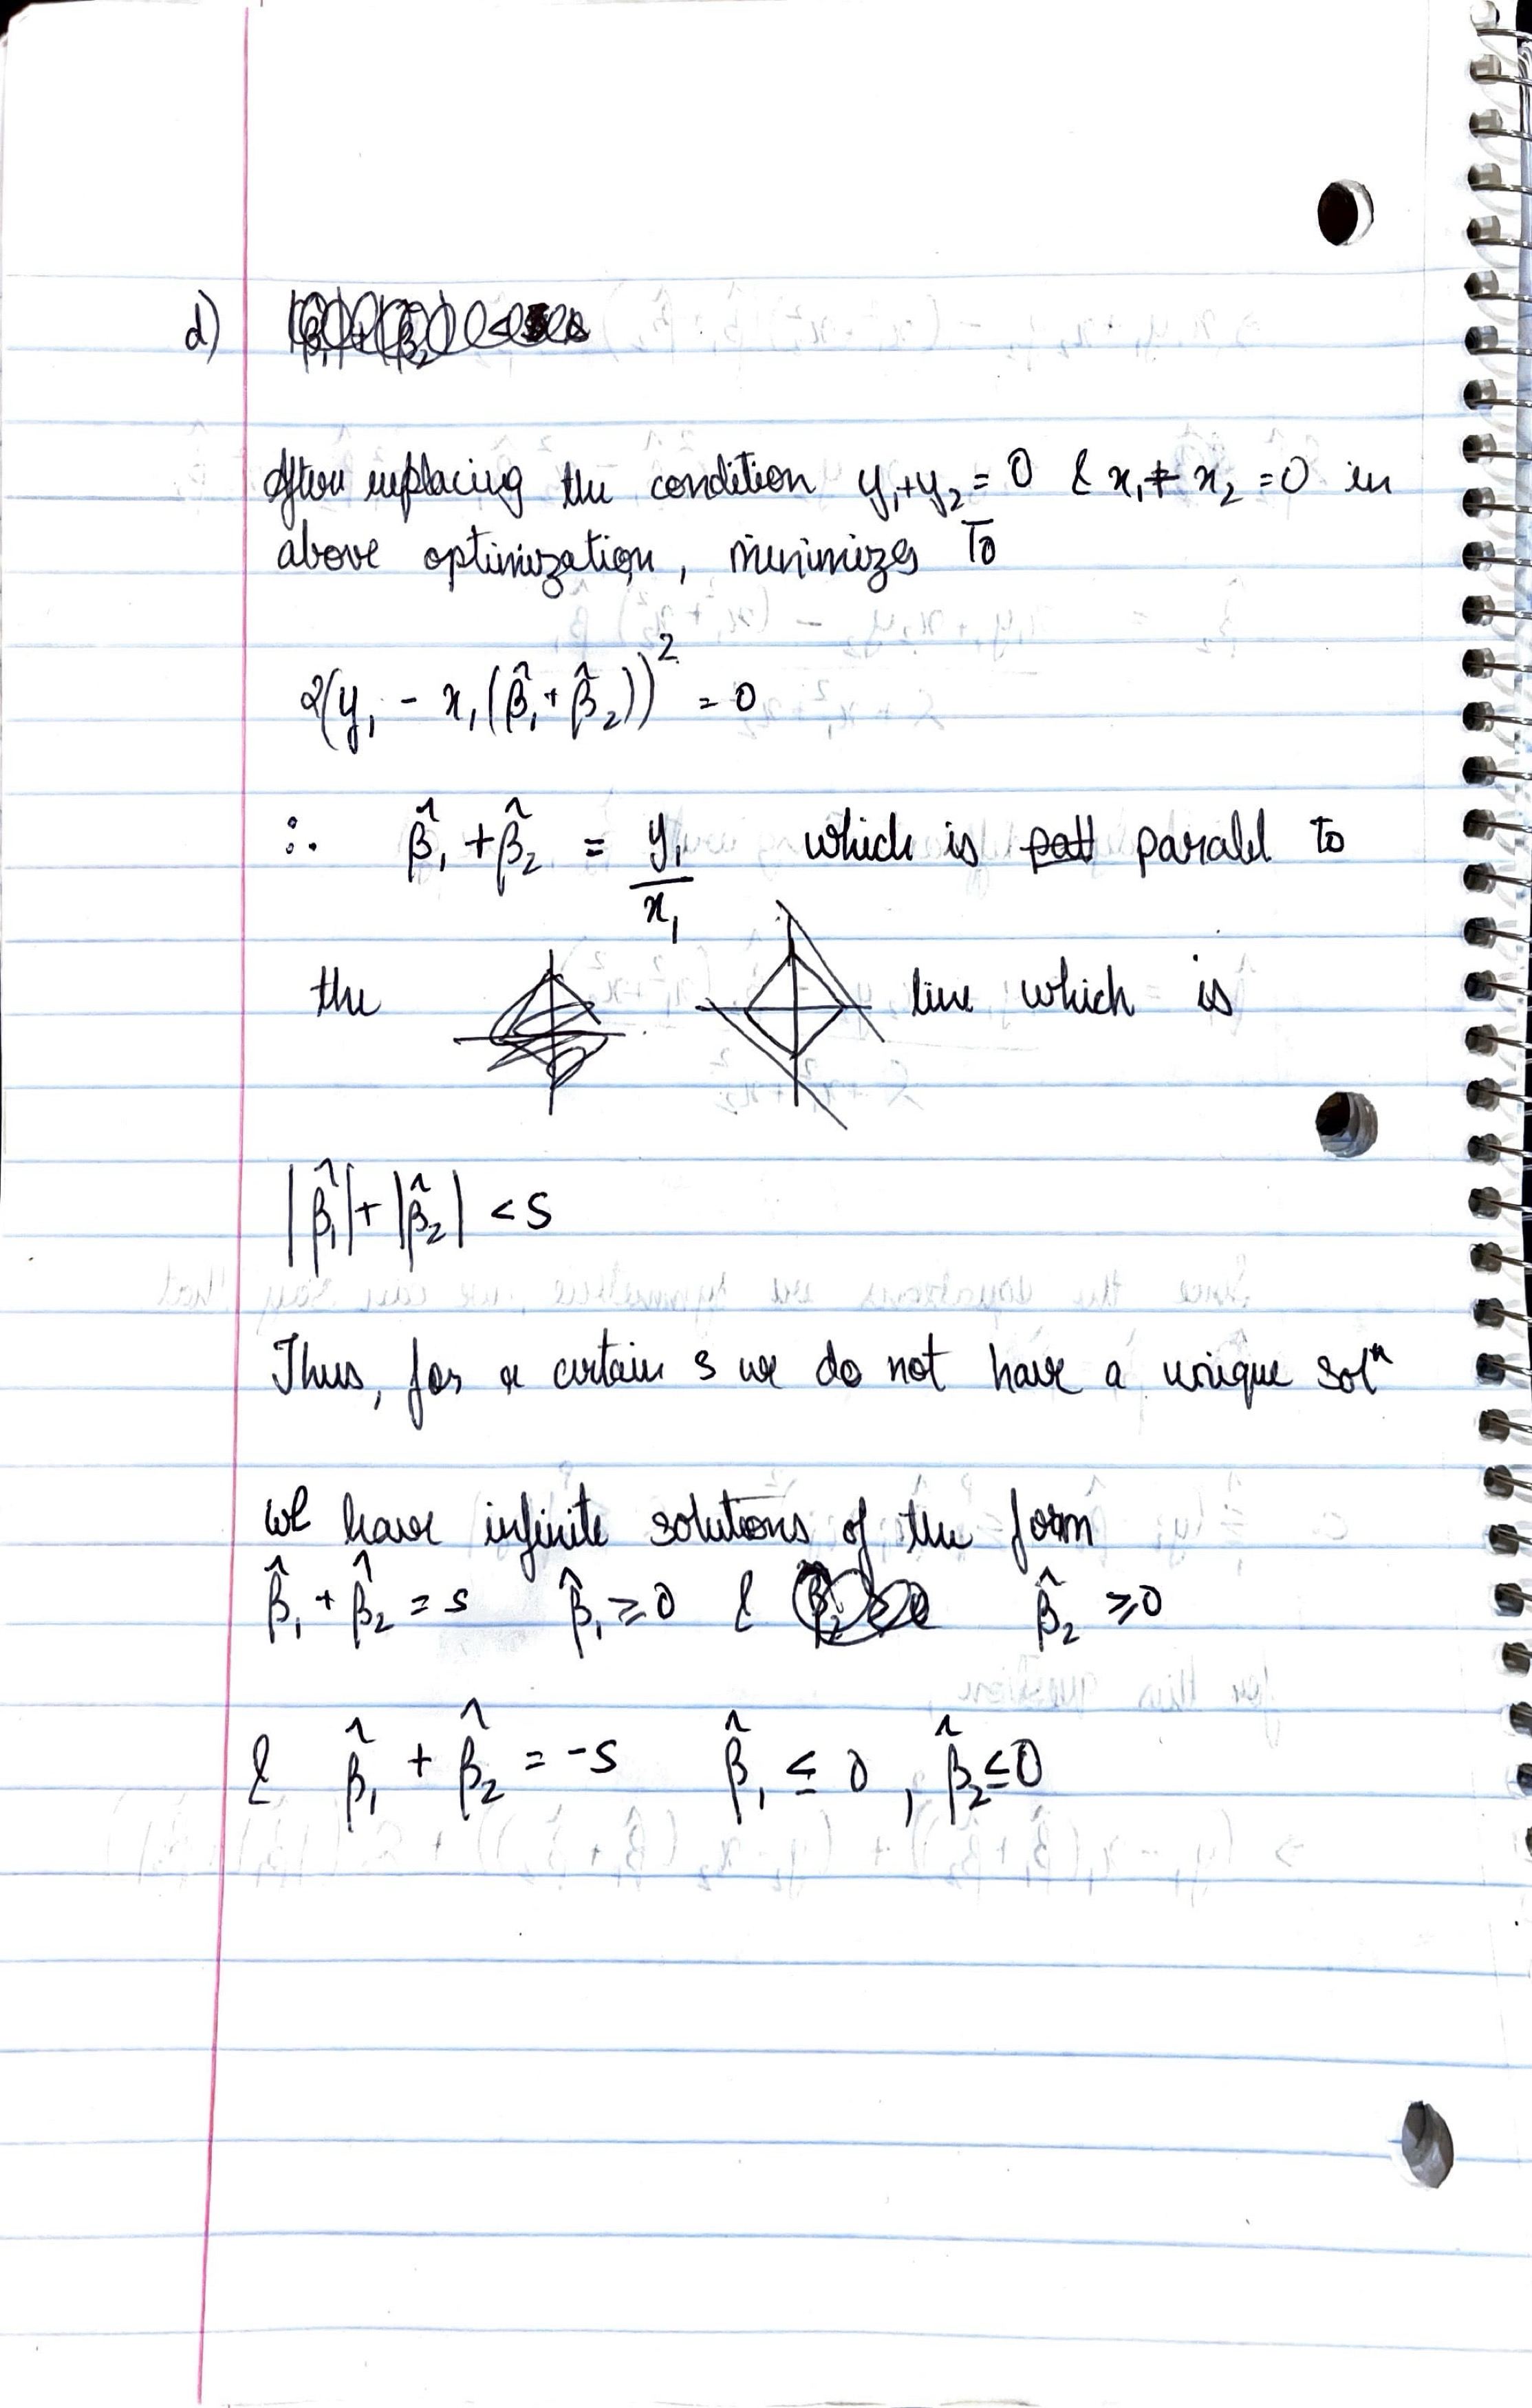

## 4. ISLR 8.4.5

* __Majority Voting__ : Out of 10 samples, Count(P(Class is Red|X)) >=0.5 is 6. Thus by majority voting, we can classify the sample X to be Red.  
   
* __Average Probability__ : The average probability for P(Class is Red|X) is 4.5/10 = 0.45. Thus, the sample X is classified as not Red, which is Green.

## 5. ISLR 9.7.3

We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label.   
Obs.    X1  X2  Y   
1       3   4   Red    
2       2   2   Red   
3       4   4   Red   
4       1   4   Red   
5       2   1   Blue   
6       4   3   Blue   
7       4   1   Blue  

* #### a . Sketch the observations. 

In [57]:
df = pd.DataFrame({'X1': [3,2,4,1,2,4,4], 'X2': [4,2,4,4,1,3,1], 'Y':['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']})
print(df)

   X1  X2     Y
0   3   4   Red
1   2   2   Red
2   4   4   Red
3   1   4   Red
4   2   1  Blue
5   4   3  Blue
6   4   1  Blue


<Axes: xlabel='X1', ylabel='X2'>

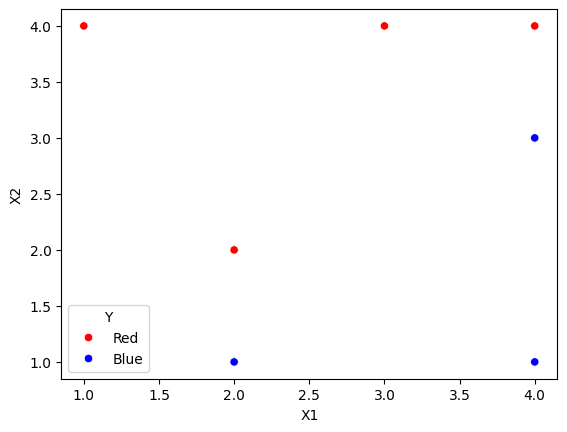

In [58]:
sns.scatterplot(x='X1', y='X2', hue='Y', data=df, palette=['red', 'blue'])

In [59]:
df['y_color'] = df['Y']
df['Y'].replace({'Red': 0, 'Blue': 1}, inplace = True)
print(df['Y'])

0    0
1    0
2    0
3    0
4    1
5    1
6    1
Name: Y, dtype: int64


In [60]:
svm_model = svm.SVC(kernel='linear', C=1000)
svm_model.fit(df[['X1', 'X2']], df['Y'])
y_pred = svm_model.predict(df[['X1', 'X2']])

/var/folders/xx/2rr5rxfn4fg3jq226phx17j00000gn/T/ipykernel_66635/3347179185.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['X1'], df['X2'], c=df['y_color'], s=30, cmap=plt.cm.Paired)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


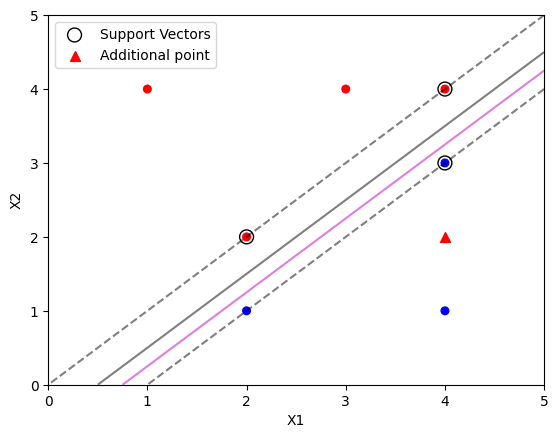

<Figure size 800x800 with 0 Axes>

In [61]:
plt.scatter(df['X1'], df['X2'], c=df['y_color'], s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
plt.figure(figsize = (8, 8))
DecisionBoundaryDisplay.from_estimator(
    svm_model,
    df[['X1', 'X2']],
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_model.decision_function(xy).reshape(XX.shape)
# line1 = ax.contour(XX, YY, Z, colors='g', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
line2 = ax.contour(XX, YY, Z-0.5, colors='m', levels=[0], alpha=0.5, linestyles=['-'])

# plot support vectors
ax.scatter(
    svm_model.support_vectors_[:, 0],
    svm_model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
    label = "Support Vectors",
)
ax.scatter([4.0], [2.0], color = 'r', marker = '^', s = 50, label = "Additional point")
ax.legend(loc='upper left')
plt.show()

In [62]:
print('Coefficients : ', svm_model.intercept_, svm_model.coef_)
print('Support Vectors : ',svm_model.support_vectors_)

Coefficients :  [-1.0004096] [[ 1.9998464 -1.9996928]]
Support Vectors :  [[2. 2.]
 [4. 4.]
 [4. 3.]]


* __b.__ : The hyperplane is represented by the solid black line.  
* __c.__ : $\beta_0 = 1, \beta_1 = -2, \beta_2 = 2$  
    * Thus, the equation would be if $2X_2 - 2X_1 + 1 > 0$ classify to red, otherwise blue. The equation can be further simplified to $X_2 - X_1 + 0.5 > 0$ then red else blue.  
* __d.__ : The magin for the maximum margin hyperplane is denoted using dashed lines in the above plot.  
* __e.__ : The support vectors are indicated on the plot using circles [2,2], [4,4], [4,3].   
* __f.__ : Since the 7th vector is far away from the decision boundary or the hyperplane, its slight movement will not affect the maximal margin hyperplane.  
* __g.__ : The green line in the plot is the non-optimal separating hyperplane. The equation for this plane would be $X_2 - X_1 + 0.75 > 0$
* __h.__ : If we add a point [4,2] with class red, the classes become inseparable by a hyperplane.